In [ ]:
!conda install -c conda-forge pygam xgboost shap --solver=classic -y

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import shap
import xgboost
import pygam
print("All advanced libraries loaded successfully!")

All advanced libraries loaded successfully!


In [5]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap

# 1. Setup the Root Directory (The "Brain" of your paths)
REPO_ROOT = os.path.dirname(os.getcwd()) if os.path.basename(os.getcwd()) == "notebooks" else os.getcwd()

# 2. Add scripts to the path so we can import our custom modules
sys.path.insert(0, os.path.join(REPO_ROOT, "scripts"))

# 3. Import your cleaned-up logic
from core_metrics import run_ols_pipeline, FEATURE_LABELS
from advanced_metrics import (
    run_xgboost_shap_pipeline, 
    generate_systematic_comparison, 
    run_gam_pipeline, 
    analyze_gam_nonlinearities
)

# 4. Global plotting settings
sns.set_theme(style="whitegrid")

path_nhgis = os.path.join(REPO_ROOT, "data", "processed", "nhgis_analysis_ready.csv")
df = pd.read_csv(path_nhgis)
print("Loaded Data Shape:", df.shape)

Loaded Data Shape: (84529, 38)


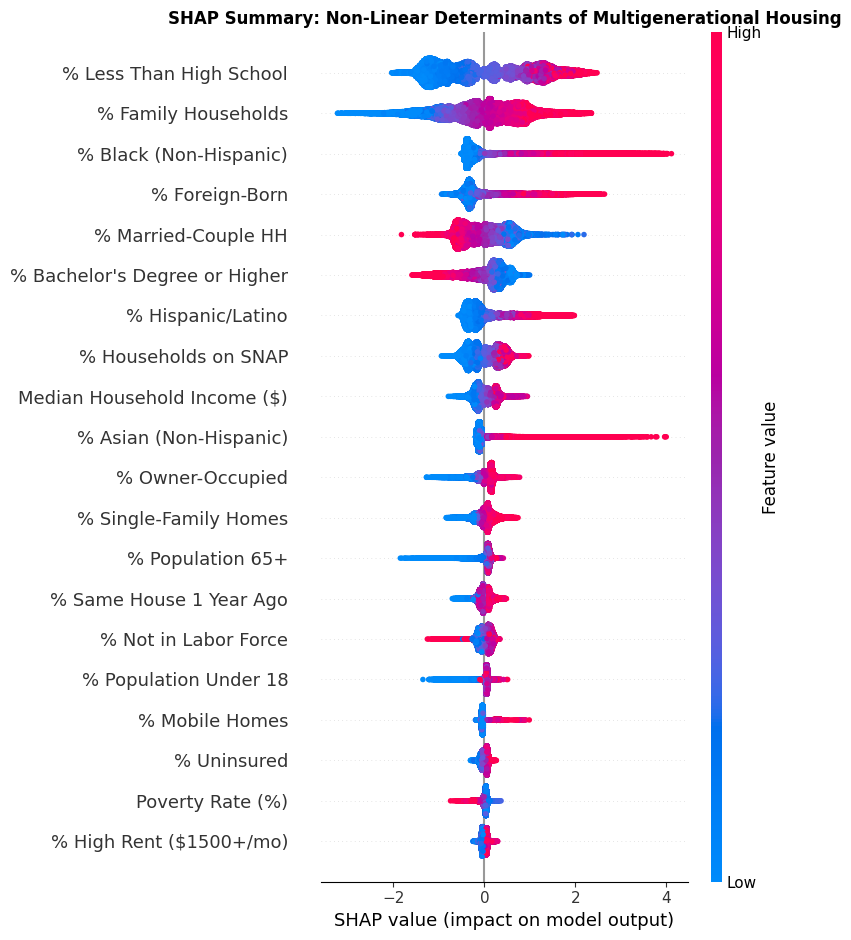

In [10]:
xgb_results = run_xgboost_shap_pipeline(df)

shap_values = xgb_results["shap_values"]
X_features = xgb_results["X"]

# Rename columns to human-readable labels for the plot
X_labeled = X_features.rename(columns={c: FEATURE_LABELS.get(c, c) for c in X_features.columns})
shap_values.feature_names = list(X_labeled.columns)

plt.figure(figsize=(10, 8))
plt.title("SHAP Summary: Non-Linear Determinants of Multigenerational Housing", fontweight="bold")
shap.summary_plot(shap_values, X_labeled, plot_type="dot", show=False)
plt.tight_layout()
plt.show()

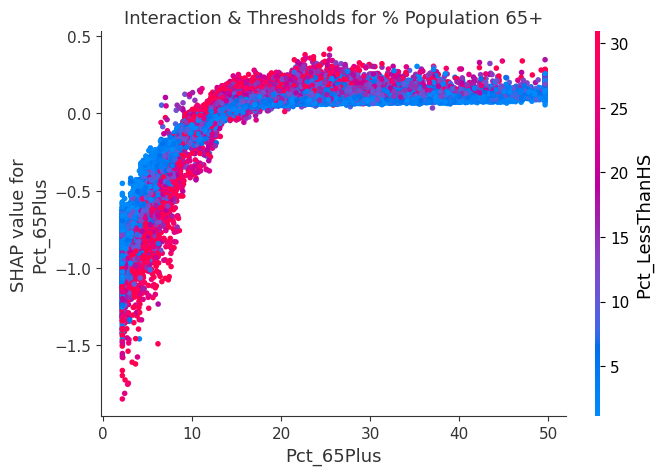

In [11]:
# Look at the top feature (e.g., Median HH Income or Pct_ForeignBorn)
top_feature = xgb_results["final_features"][0] 
top_label = FEATURE_LABELS.get(top_feature, top_feature)

shap.dependence_plot(
    top_feature, 
    shap_values.values, 
    X_features, 
    feature_names=X_features.columns,
    title=f"Interaction & Thresholds for {top_label}"
)

File saved to: /Users/elyas/vscode/capstone_multigen_housing_econometric_analysis/output/nhgis_model_comparison.csv

--- SYSTEMATIC MODEL COMPARISON ---
                        Label  OLS_Coef OLS_Sig  SHAP_Importance  SHAP_Elasticity  Potential_NonLinearity
      % Less Than High School  0.050347     ***         0.935261         0.195284                   False
          % Family Households  0.113036     ***         0.682887         0.531463                   False
       % Black (Non-Hispanic)  0.036126     ***         0.444710         0.050633                   False
               % Foreign-Born  0.051483     ***         0.444281         0.077230                   False
          % Married-Couple HH -0.115669     ***         0.400537         0.197602                   False
% Bachelor's Degree or Higher -0.051136     ***         0.385734         0.120065                   False
            % Hispanic/Latino  0.035322     ***         0.346743         0.051347                   False

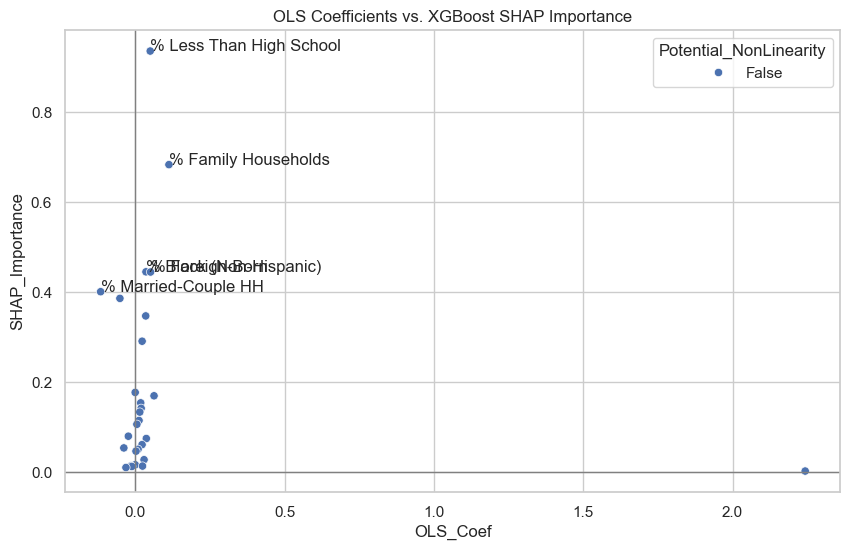

In [ ]:
import os
from advanced_metrics import generate_systematic_comparison
from core_metrics import run_ols_pipeline

# 1. Run the OLS Baseline (if not already in memory)
ols_results = run_ols_pipeline(df)

# 2. Run the XGBoost Pipeline
xgb_results = run_xgboost_shap_pipeline(df)

# 3. Generate the systematic report
# 3. Generate the systematic report using the absolute path to your existing 'output' folder
output_path_xgb = os.path.join(REPO_ROOT, "output", "nhgis_model_comparison.csv")

comparison_report = generate_systematic_comparison(
    ols_results, 
    xgb_results, 
    output_path=output_path_xgb
)

# Display the Top 10 determinants for a side-by-side read
display_cols = ["Label", "OLS_Coef", "OLS_Sig", "SHAP_Importance", "SHAP_Elasticity", "Potential_NonLinearity"]
print("\n--- SYSTEMATIC MODEL COMPARISON ---")
print(comparison_report[display_cols].head(10).to_string(index=False))



--- PREDICTION PERFORMANCE COMPARISON ---
             Model      MAE     RMSE  R-Squared
    OLS (Baseline) 2.290785 3.063280   0.476162
XGBoost (Advanced) 2.198581 2.940867   0.517192


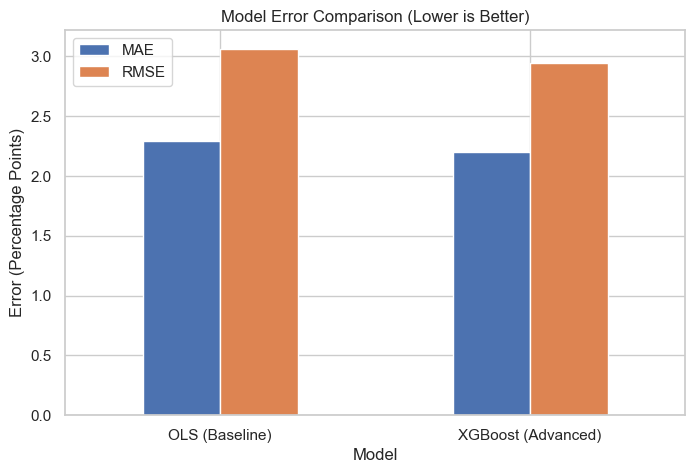

In [9]:
from advanced_metrics import compare_model_performance

# 1. Run the comparison
performance_df = compare_model_performance(ols_results, xgb_results)

# 2. Display the results
print("\n--- PREDICTION PERFORMANCE COMPARISON ---")
print(performance_df.to_string(index=False))

# 3. Visualize the "Error Gap"
performance_df.set_index("Model")[["MAE", "RMSE"]].plot(kind="bar", figsize=(8, 5))
plt.title("Model Error Comparison (Lower is Better)")
plt.ylabel("Error (Percentage Points)")
plt.xticks(rotation=0)
plt.show()

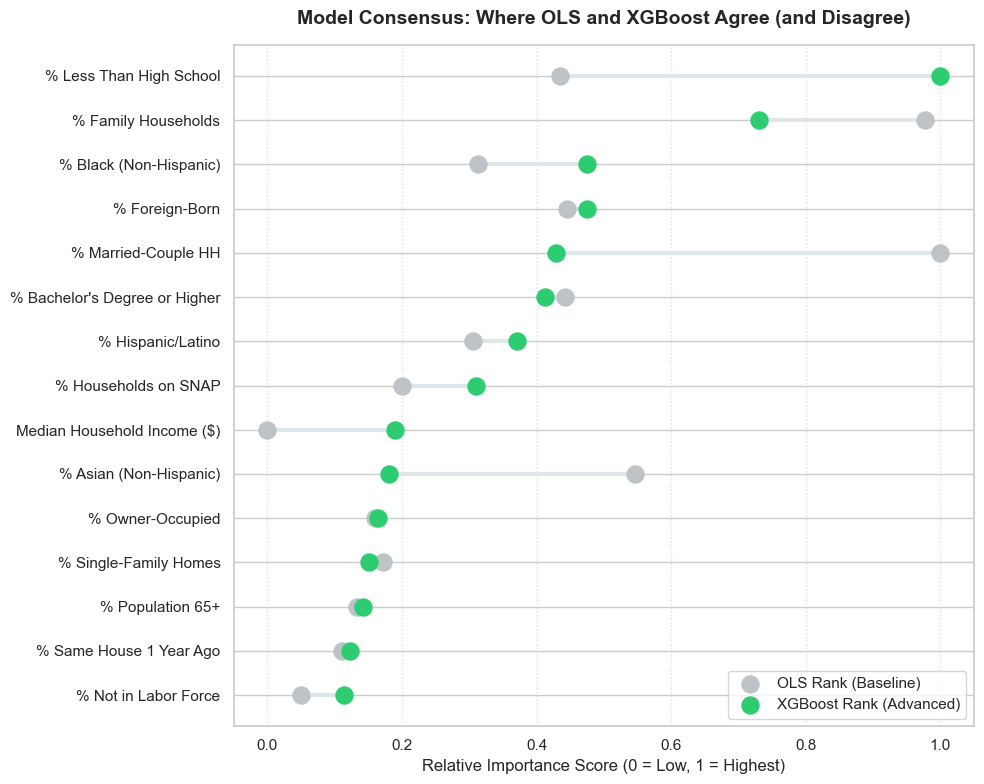

In [11]:
# Focus on the Top 15 variables for maximum readability
top_15 = comparison_report.head(15).copy()

# Normalize scores to 0-1 so we can compare the "Rank" accurately on one axis
top_15['OLS_Magnitude'] = top_15['OLS_Coef'].abs()
top_15['OLS_Score'] = top_15['OLS_Magnitude'] / top_15['OLS_Magnitude'].max()
top_15['XGB_Score'] = top_15['SHAP_Importance'] / top_15['SHAP_Importance'].max()

# Sort by the most important variable in XGBoost
top_15 = top_15.sort_values('XGB_Score', ascending=True)

plt.figure(figsize=(10, 8))

# Draw the "Dumbbell" lines connecting the two model scores
plt.hlines(y=top_15['Label'], xmin=top_15['OLS_Score'], xmax=top_15['XGB_Score'], color='#dfe6e9', linewidth=3, zorder=1)

# Draw the OLS dots
plt.scatter(top_15['OLS_Score'], top_15['Label'], color='#bdc3c7', s=150, label='OLS Rank (Baseline)', zorder=2)

# Draw the XGBoost dots
plt.scatter(top_15['XGB_Score'], top_15['Label'], color='#2ecc71', s=150, label='XGBoost Rank (Advanced)', zorder=3)

# Style the chart
plt.title("Model Consensus: Where OLS and XGBoost Agree (and Disagree)", fontsize=14, fontweight='bold', pad=15)
plt.xlabel("Relative Importance Score (0 = Low, 1 = Highest)", fontsize=12)
plt.legend(loc='lower right', frameon=True)
plt.grid(axis='x', linestyle=':', alpha=0.6)

plt.tight_layout()
plt.show()

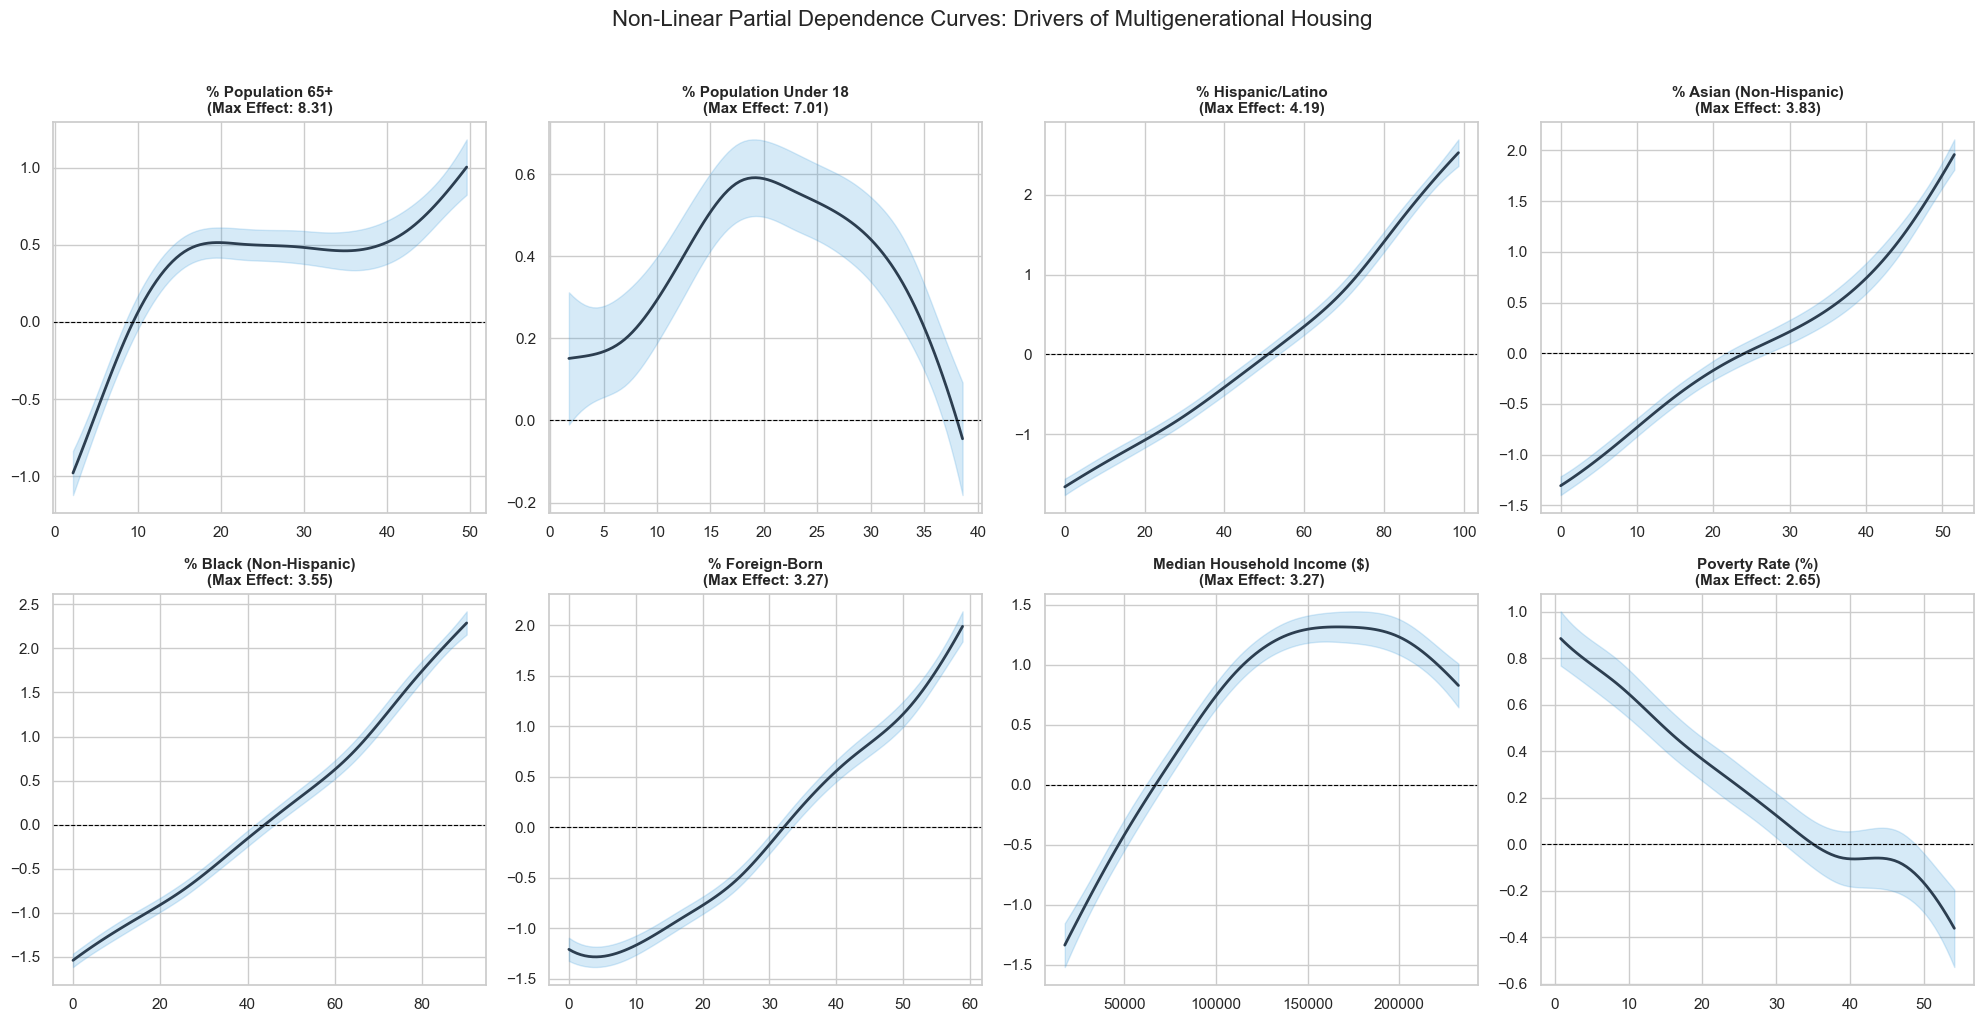

Detailed GAM analysis saved to: /Users/elyas/vscode/capstone_multigen_housing_econometric_analysis/output/gam_nonlinearity_analysis.csv


In [12]:
#GAM Partial Dependence Curves

import os
import matplotlib.pyplot as plt
import pandas as pd
from advanced_metrics import run_gam_pipeline, analyze_gam_nonlinearities
from core_metrics import FEATURE_LABELS

# 1. Run the Analysis
gam_results = run_gam_pipeline(df)
gam_analysis = analyze_gam_nonlinearities(gam_results)

# 2. Systematic Plotting of top 8 determinants
# We use an 8-panel grid for a comprehensive view
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

features = gam_results["final_features"]
model = gam_results["model"]

for i in range(8):
    ax = axes[i]
    if i < len(features):
        XX = model.generate_X_grid(term=i)
        pdep, confi = model.partial_dependence(term=i, X=XX, width=0.95)
        
        ax.plot(XX[:, i], pdep, color="#2c3e50", lw=2)
        ax.fill_between(XX[:, i], confi[:, 0], confi[:, 1], color='#3498db', alpha=0.2)
        
        label = FEATURE_LABELS.get(features[i], features[i])
        ax.set_title(f"{label}\n(Max Effect: {gam_analysis.iloc[i]['Max_Effect']:.2f})", fontsize=11, fontweight='bold')
        ax.axhline(0, color='black', linestyle='--', linewidth=0.8)
    else:
        ax.axis('off')

plt.suptitle("Non-Linear Partial Dependence Curves: Drivers of Multigenerational Housing", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

# 3. Export the Results
# 3. Export the Results directly to the existing root-level 'output' folder
output_path_gam = os.path.join(REPO_ROOT, "output", "gam_nonlinearity_analysis.csv")
gam_analysis.to_csv(output_path_gam, index=False)
print(f"Detailed GAM analysis saved to: {output_path_gam}")

In [13]:
# 1. Run the analysis (if not already in memory)
from advanced_metrics import analyze_gam_nonlinearities

# 2. Generate the results table
gam_summary_table = analyze_gam_nonlinearities(gam_results)

# 3. Format and print the table for easy reading
print("\n" + "="*80)
print("GAM NON-LINEARITY & EFFECT SIZE SUMMARY")
print("="*80)

# Select and rename columns for clarity
display_df = gam_summary_table[[
    "Label", "Max_Effect", "Trend", "Is_NonLinear"
]].copy()

display_df.columns = ["Variable Label", "Impact Range (Max Effect)", "Trend Type", "Wiggly/Non-Linear?"]

# Display the top 15 determinants
print(display_df.head(15).to_string(index=False))
print("="*80)


GAM NON-LINEARITY & EFFECT SIZE SUMMARY
               Variable Label  Impact Range (Max Effect)             Trend Type  Wiggly/Non-Linear?
          % Married-Couple HH                   8.310912              Monotonic                True
          % Family Households                   7.010131              Monotonic                True
            % Hispanic/Latino                   4.192271              Monotonic                True
       % Black (Non-Hispanic)                   3.826589              Monotonic               False
% Bachelor's Degree or Higher                   3.548174 Non-monotonic/U-shaped                True
               % Foreign-Born                   3.273209 Non-monotonic/U-shaped                True
       % Asian (Non-Hispanic)                   3.267242              Monotonic                True
  Median Household Income ($)                   2.653857 Non-monotonic/U-shaped               False
         % Limited English HH                   2.246133   

In [16]:
# 1. Capture the VIF values from the preparation stage
# We recalculate them here for the final report
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm

X_vif = sm.add_constant(ols_results["work_df"][ols_results["final_features"]])
vif_data = pd.DataFrame({
    "Feature": ols_results["final_features"],
    "VIF": [variance_inflation_factor(X_vif.values, i + 1) for i in range(len(ols_results['final_features']))]
})

# 2. Merge everything into the Final Master Table
final_master = comparison_report.merge(
    gam_summary_table[['Label', 'Max_Effect', 'Trend', 'Is_NonLinear']], 
    on='Label', 
    how='left'
).merge(
    vif_data.merge(pd.DataFrame(FEATURE_LABELS.items(), columns=['Feature', 'Label']), on='Feature')[['Label', 'VIF']],
    on='Label',
    how='left'
)

# 3. Format for the Expert Hand-off
final_cols = [
    'Label', 'OLS_Coef', 'SHAP_Elasticity', 'Max_Effect', 'VIF', 'Trend'
]

print("--- FINAL MASTER DETERMINANT SYNTHESIS (EXPERT VERSION) ---")
print(final_master[final_cols].head(10).to_string(index=False))

--- FINAL MASTER DETERMINANT SYNTHESIS (EXPERT VERSION) ---
                        Label  OLS_Coef  SHAP_Elasticity  Max_Effect      VIF                  Trend
      % Less Than High School  0.050347         0.195284    2.114478 3.653259              Monotonic
          % Family Households  0.113036         0.531463    7.010131 7.026854              Monotonic
       % Black (Non-Hispanic)  0.036126         0.050633    3.826589 1.949157              Monotonic
               % Foreign-Born  0.051483         0.077230    3.273209 4.291139 Non-monotonic/U-shaped
          % Married-Couple HH -0.115669         0.197602    8.310912 8.389767              Monotonic
% Bachelor's Degree or Higher -0.051136         0.120065    3.548174 5.441072 Non-monotonic/U-shaped
            % Hispanic/Latino  0.035322         0.051347    4.192271 3.675475              Monotonic
         % Households on SNAP  0.023209         0.057457    1.179719 3.803284 Non-monotonic/U-shaped
  Median Household Income ($)  